## Exploratory Data Analysis

In [1]:
#Importing the libraries needed for EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
#Loaading the dataset
emissions_data = pd.read_csv("Emissions_Canada.csv")


In [3]:
#Converting all columns names to lowercase
emissions_data.columns = emissions_data.columns.str.lower()

# Remove leading/trailing spaces and replace internal spaces with underscores
emissions_data.columns = emissions_data.columns.str.strip().str.replace(' ', '_')

print(emissions_data.columns.tolist())


['make', 'model', 'vehicle_class', 'engine_size(l)', 'cylinders', 'transmission', 'fuel_type', 'fuel_consumption_city_(l/100_km)', 'fuel_consumption_hwy_(l/100_km)', 'fuel_consumption_comb_(l/100_km)', 'fuel_consumption_comb_(mpg)', 'co2_emissions(g/km)']


In [4]:
emissions_data.rename(columns={'co2_emissions(g/km)': 'co2_emissions'}, inplace=True)


In [5]:
#Selecting the feature columns and the target column
target_variable = 'co2_emissions'
numerical_features = ['engine_size(l)', 'cylinders']
categorical_feature = 'fuel_type'


In [6]:
#Transforming the data

transformed_numerical_features = np.log(emissions_data[numerical_features])
transformed_target_variable = np.log(emissions_data[target_variable])


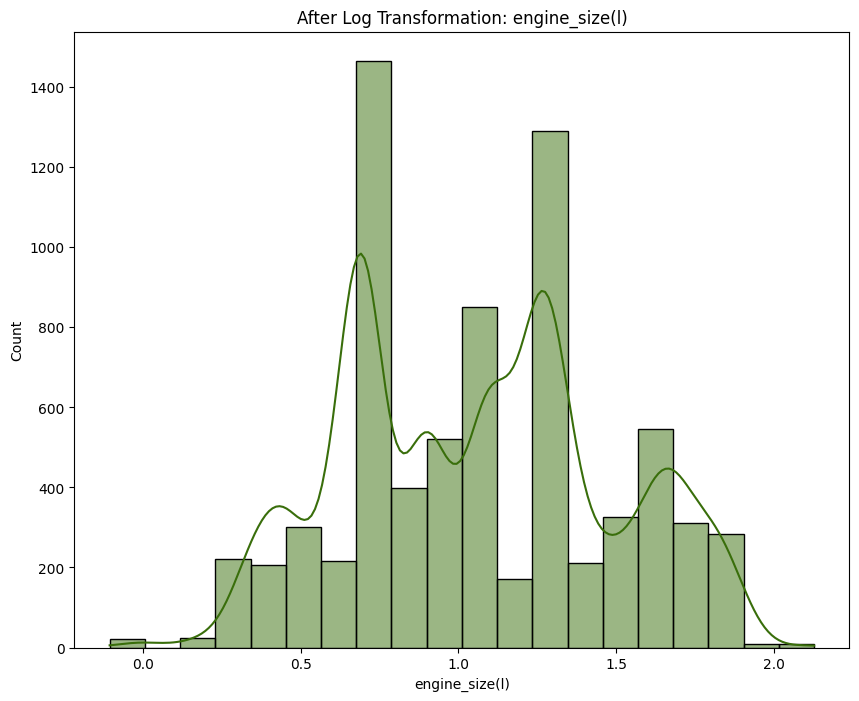

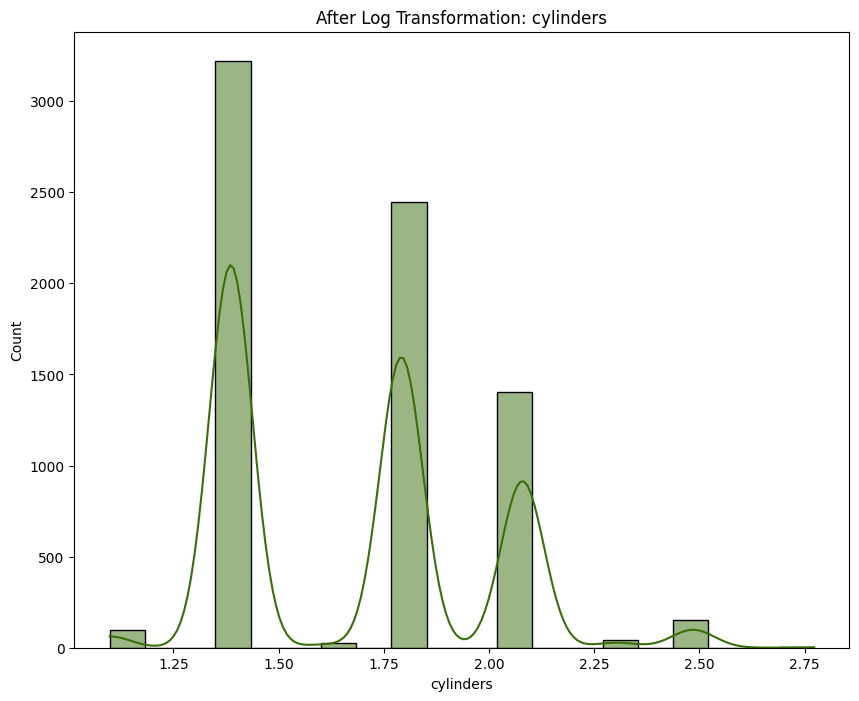

In [7]:
#Transforming the numerical data

for feature in transformed_numerical_features:
    plt.figure(figsize=(10,8))
    sns.histplot(transformed_numerical_features[feature], kde=True, bins=20, color="#396e0b", edgecolor="black")
    plt.title(f"After Log Transformation: {feature}")
    plt.show()

# Plot histograms of each column after the log transformation
#I applied a log transformation because the data is highly skewed and since I'll be modeling a linear regression model, i need to transform the data
#to make it assume a normal distribution and have a constant variance before the linear regression will work


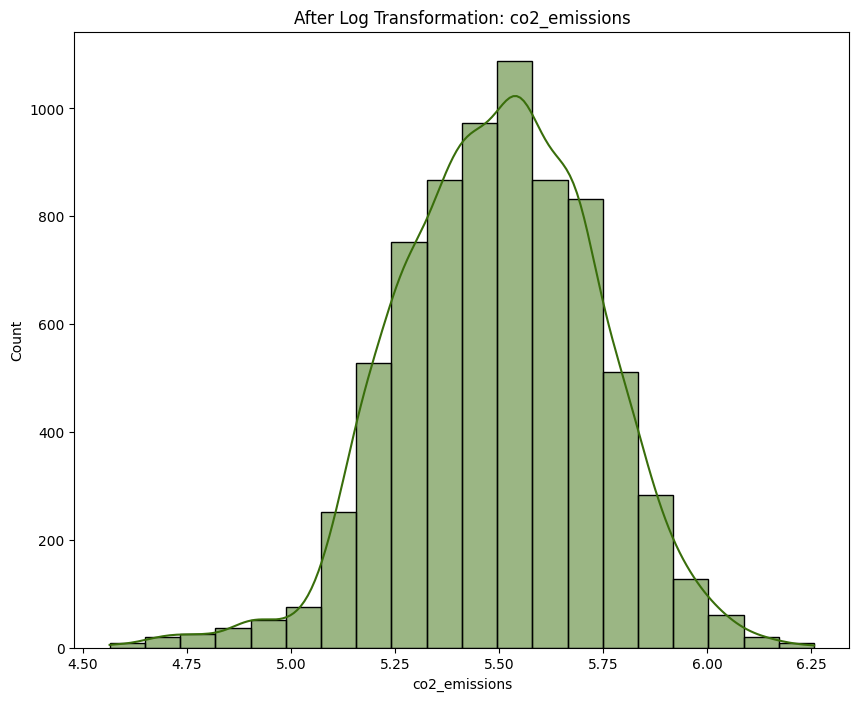

In [13]:
plt.figure(figsize=(10,8))
sns.histplot(transformed_target_variable, kde=True, bins=20, color="#396e0b", edgecolor="black")
plt.title(f"After Log Transformation: {target_variable}")
plt.show()

### Model Training and Evaluation

In [8]:
# Import ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import joblib, os

/home/yaa_baby/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


The code below trains 4 different models and has an additional 2 models for prediction

In [10]:
# Combine transformed numerical features + categorical into one DataFrame that is X
X = pd.concat([transformed_numerical_features, emissions_data[[categorical_feature]]], axis=1)
y = transformed_target_variable.copy()


# One-Hot Encode the categorical feature

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_categorical_feature = encoder.fit_transform(X[[categorical_feature]])

# Convert encoded columns into a DataFrame
encoded_cat_df = pd.DataFrame(
    encoded_categorical_feature,
    columns=encoder.get_feature_names_out([categorical_feature]),
    index=X.index
)

# Merge numerical and encoded categorical columns
X_encoded = pd.concat([X.drop(columns=[categorical_feature]), encoded_cat_df], axis=1)


#Spliting the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Scale Numerical Features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define Models

models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVM (RBF)': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predicted_y = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, predicted_y)
    rmse = mean_squared_error(y_test, predicted_y, squared=False)
    r2 = r2_score(y_test, predicted_y)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"{name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Convert results dictionary to a DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

# Create folder to save models
os.makedirs("model", exist_ok=True)

# Select best model based on highest R²
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
print("Best model:", best_model_name)

# Retrieve best model object from the dictionary
best_model = models[best_model_name]

# Save model + encoder + scaler
joblib.dump(best_model, f"model/{best_model_name.replace(' ', '_').lower()}_model.pkl")
joblib.dump(encoder, "model/encoder.pkl")
joblib.dump(scaler, "model/scaler.pkl")

print("✅ Model, encoder, and scaler saved successfully!")



Linear Regression → MAE: 0.09, RMSE: 0.13, R²: 0.72
KNN → MAE: 0.09, RMSE: 0.12, R²: 0.76
Random Forest → MAE: 0.08, RMSE: 0.11, R²: 0.77
SVM (RBF) → MAE: 0.09, RMSE: 0.12, R²: 0.73
Gradient Boosting → MAE: 0.08, RMSE: 0.12, R²: 0.76
XGBoost → MAE: 0.08, RMSE: 0.11, R²: 0.77
Best model: XGBoost
✅ Model, encoder, and scaler saved successfully!
